### PREPROCESSING 

In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [208]:
pip install --upgrade streamlit streamlit_option_menu

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importation des différents datasets nécessaires
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
links = pd.read_csv('links.csv')
title_principals = pd.read_csv('data-7.tsv', sep = '\t')

In [4]:
# lien entre les bases de données MovieLens et Imdb
movies = movies.merge(right = links, on = 'movieId', how = 'left')
movies.imdbId = movies.imdbId.apply(lambda x : 'tt' + (7 - len(str(x))) * str(0) + str(x))
movies = movies.drop(columns='tmdbId')
movies = movies.rename(columns = {'imdbId' : 'tconst'})

In [5]:
# Hypothèses en nombre de films et nombre d'utilisateurs
nombre_de_films = 1500
nb_users = 1500

In [6]:
# Création d'un DataFrame movie_stats qui contient pour chaque ligne le film et la moyenne bayesian des notations
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby(['movieId'])['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

movie_stats = movie_stats.merge(movies['movieId'])
best_movies_sorted = movie_stats.sort_values('bayesian_avg', ascending=False) 
# On obtient le classement des meilleurs films avec la moyenne bayesian, c'est à dire la moyenne des notations 
# pondérée du nombre de votes

In [7]:
# on réduit le DataFrame movies en ne gardant que les k (= nombre_de_films) films les mieux notés
movies_reduced = movies.merge(right = best_movies_sorted[:nombre_de_films], on = 'movieId', how = 'right')

# on enlève la moyenne normale et le décompte
movies_reduced = movies_reduced.drop(columns=['mean', 'count'])

# Notre base de donnée de films est prête pour utilisation

In [8]:
# on diminue le dataframe ratings avec prise en compte que des k films de movies_reduced

ratings_reduced = movies_reduced.merge(ratings) 

# on diminue ratings_reduced en ne gardant que les p users ayant effectué le plus de notations
liste = list(ratings_reduced.groupby('userId').agg('count').sort_values(by = 'rating', ascending = False)[:nb_users].index) 
ratings_reduced = ratings_reduced[ratings_reduced['userId'].isin(liste)]

In [9]:
# On réindexe les matrices movies_reduced et rating_reduced

# Création d'un dico pour faire des nouveaux id aux items + création nouvelle colonne au DataFrame
liste_movieid = list(movies_reduced.movieId.unique())
new_movieid = [i for i in range(len(movies_reduced.movieId.unique()))]
dico_movie = dict(zip(liste_movieid, new_movieid))

# Création d'un dico pour faire des nouveaux id aux user_id + création nouvelle colonne au DataFrame
liste_userid = list(ratings_reduced.userId.unique())
new_userid = [i for i in range(len(ratings_reduced.userId.unique()))]
dico_user = dict(zip(liste_userid, new_userid))


# Il est primordial de comprendre ici qu'il ne faut pas faire de boucle !!! Il faut utiliser les super propriétés de pandas. 
# Ici la boucle tournerait en énormément de temps, alors que là c'est quasiment instantané.

movies_reduced['new_movieid'] = movies_reduced.movieId.apply(lambda x : dico_movie[x])
ratings_reduced['new_movieid'] = ratings_reduced.movieId.apply(lambda x : dico_movie[x])
ratings_reduced['new_userid'] = ratings_reduced.userId.apply(lambda x : dico_user[x])



# On change la position des colonnes du df pour se remettre dans la configuration voulue
movies_reduced = movies_reduced.reindex(columns=["new_movieid",  "title", "genres", "tconst", "bayesian_avg"])
movies_reduced = movies_reduced.rename(columns={'new_movieid' : 'movieId'})
ratings_reduced = ratings_reduced.reindex(columns=["new_userid", "new_movieid", "rating"])
ratings_reduced = ratings_reduced.rename(columns={'new_movieid' : 'movieId', 'new_userid' : 'userId'})
ratings_reduced = ratings_reduced.reset_index()
ratings_reduced = ratings_reduced.drop(columns='index')

movies_reduced.to_csv('movies_reduced.csv', index=False)
ratings_reduced.to_csv('ratings_reduced.csv', index=False)



### Content-Based Filtering

In [10]:
# cbf -> content_based filtering
movies_cbf = movies_reduced.drop(columns=['bayesian_avg'])

In [11]:
#on reste plutôt cablée film américain. On assume ce choix, quitte à un jour faire une version française. Mais on a classé les films par 
#la moyenne bayesian ce qui nous laisse forcément que des films américains. Donc on regarde les actors dans le top monde.

from bs4 import BeautifulSoup as bs
import requests

url_actors = 'https://www.imdb.com/list/ls050274118/'
url_actresses = 'https://www.imdb.com/list/ls000055475/'
url_directors = 'https://www.imdb.com/list/ls053823383/'
page_actors = requests.get(url_actors)
page_actresses = requests.get(url_actresses)
page_directors = requests.get(url_directors)

soup_actors = bs(page_actors.content, "lxml")
soup_actresses = bs(page_actresses.content, "lxml")
soup_directors = bs(page_directors.content, "lxml")

actor_ids = soup_actors.find_all('div', class_ ='lister-item-image')
actress_ids = soup_actresses.find_all('div', class_ ='lister-item-image')
director_ids = soup_directors.find_all('div', class_ ='lister-item-image')

list_best_actors = []
list_best_actresses = []
list_best_directors = []


for i in range(len(actor_ids)):
    list_best_actors.append(actor_ids[i].find('a')['href'].split('/')[2])

for i in range(len(actress_ids)):
    list_best_actresses.append(actress_ids[i].find('a')['href'].split('/')[2])

for i in range(len(director_ids)):
    list_best_directors.append(director_ids[i].find('a')['href'].split('/')[2])

# on repère les doublons éventuels

for i in list_best_actors:
    for j in list_best_directors:
        if i == j:
            list_best_directors.remove(j)
            break

for i in list_best_actresses:
    for j in list_best_directors:
        if i == j:
            list_best_directors.remove(j)
            break
        
#TIME -  12s

In [12]:
# traitement du dataset movies

movies_cbf.genres = movies_cbf.genres.apply(lambda x : x.split('|'))

# on lie movies_reduced avec les principaux personnages de chaque film.

movies_cbf = movies_cbf.merge(right = title_principals, on = 'tconst', how = 'left') #15s
movies_cbf = movies_cbf.drop(columns=['job', 'characters'])

In [13]:
# Création d'une liste de listes comprenant tous les personnages principaux pour un film donné

liste_iter = [] 
liste_globale = []

for i in range(nombre_de_films) :
    for j in movies_cbf[movies_cbf.movieId == i].nconst : 
        liste_iter.append(j)
    liste_globale.append(liste_iter)
    liste_iter = []

In [14]:
movies_cbf['people'] = movies_cbf.movieId.apply(lambda x : liste_globale[x])

In [15]:
movies_cbf = movies_cbf.drop(columns=['nconst', 'ordering', 'category'])
movies_cbf = movies_cbf.drop_duplicates(subset=['movieId']).reset_index().drop(columns='index')
movies_cbf = movies_cbf.drop(columns=['movieId', 'title', 'tconst'])

In [16]:

#movies.genres = movies.genres.apply(lambda x : x.split('|')) - 35s
lis_genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime','Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']

lis_totale = list_best_actors + list_best_actresses + list_best_directors


for i in lis_genres:
    movies_cbf[i] = 0


for i in movies_cbf.columns[9:]:
    for j in movies_cbf.index:
        for k in movies_cbf.genres[j]:
            movies_cbf.loc[j,k] = 1 if k in lis_genres else 0

In [17]:
movies_cbf = movies_cbf.drop(columns='genres')

In [18]:
#movies.genres = movies.genres.apply(lambda x : x.split('|')) - 35s

lis_totale = list_best_actors + list_best_actresses + list_best_directors


for i in lis_totale:
    movies_cbf[i] = 0

for i in movies_cbf.columns:
    for j in movies_cbf.index:
        for k in movies_cbf.people[j]:
            if k in lis_totale :
                movies_cbf.loc[j,k] = 1  
            else :
                pass


/var/folders/nv/2_lymwv54g9335lb78fml6v80000gn/T/ipykernel_10265/3305295943.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movies_cbf[i] = 0
/var/folders/nv/2_lymwv54g9335lb78fml6v80000gn/T/ipykernel_10265/3305295943.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movies_cbf[i] = 0
/var/folders/nv/2_lymwv54g9335lb78fml6v80000gn/T/ipykernel_10265/3305295943.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

In [19]:
movies_cbf = movies_cbf.drop(columns = 'people')
movies_cbf.to_csv('movies_cbf.csv', index=False)

### Matrice de simmilarité cosinus

In [20]:
# movies_reduced[movies_reduced['title'].str.contains('Godfather')] # Code à conserver

# Le code ci-dessous permet de tester le modèle avec différents films

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movies_cbf, movies_cbf)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

# Code permettant de trouver le nom d'un film en fonction de son 

def movie_finder(title):
    return movies_reduced[movies_reduced['title'].str.contains(title)]['title'].tolist()

movie_idx = dict(zip(movies_reduced['title'], list(movies_reduced.index))) # dictionnaire clé = titre, valeur = index du titre
title = movie_finder('Inception')[0]
n_recommendations = 10

idx = movie_idx[title] # index du titre du film
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

print(f"Recommendations for {title}:")
movies_reduced['title'].iloc[similar_movies]

# ATTENTION A LA RÉINDEXATION. IL FAUT S'ASSURER QUE CELA NE PERTURBE PAS LA SUITE DES OPÉRATIONS


Dimensions of our genres cosine similarity matrix: (1500, 1500)
Recommendations for Inception (2010):


761                                       Watchmen (2009)
821                                    Source Code (2011)
125                                   Donnie Darko (2001)
244                           Boondock Saints, The (2000)
255             Killer, The (Die xue shuang xiong) (1989)
382                 Hard-Boiled (Lat sau san taam) (1992)
432                          Spanish Prisoner, The (1997)
486     Girl with the Dragon Tattoo, The (Män som hata...
1009                  Elite Squad (Tropa de Elite) (2007)
1188    Lady Vengeance (Sympathy for Lady Vengeance) (...
Name: title, dtype: object

### Matrice de simmilarité cosinus avec choix de l'utilisateur

In [21]:
Action = 1
Adventure = 1
Animation = 0
Children = 0
Comedy = 0
Crime = 0
Documentary = 0
Drama = 0
Fantasy = 0
Film_Noir = 0
Horror = 0
IMAX = 1
Musical = 0
Mystery = 0
Romance = 0
Sci_Fi = 0
Thriller = 1
War = 0
Western = 0
no_genres_listed = 0


new_line = pd.DataFrame([[Action, Adventure, Animation, Children, Comedy, Crime,Documentary, Drama, Fantasy, Film_Noir, Horror, IMAX, 
              Musical, Mystery, Romance, Sci_Fi, Thriller, War, Western, no_genres_listed]], columns=['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime','Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)'])

# Fusion des deux DataFrame
movies_cbf_user = pd.concat([movies_cbf.iloc[:,:20], new_line], ignore_index=True)
movies_cbf_user

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed)
0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
1497,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1498,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1499,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [197]:
movies_cbf

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,nm0001023,nm0167241,nm0002080,nm0526946,nm0115218,nm0001302,nm0001005,nm0001469,nm0000631,nm0514822
0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1496,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1497,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1498,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [200]:
movies_cbf.to_csv('movies_cbf.csv', index=False)
movies_reduced.to_csv('movies_reduced.csv', index=False)


In [199]:
movies_reduced

,movieId,title,genres,tconst,bayesian_avg
0,0,"Shawshank Redemption, The (1994)",Crime|Drama,tt0111161,4.431666
1,1,"Godfather, The (1972)",Crime|Drama,tt0068646,4.342857
2,2,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,tt0114814,4.315561
3,3,Schindler's List (1993),Drama|War,tt0108052,4.292849
4,4,"Godfather: Part II, The (1974)",Crime|Drama,tt0071562,4.245286
...,...,...,...,...,...
1495,1495,Strawberry and Chocolate (Fresa y chocolate) (...,Drama,tt0106966,3.480353
1496,1496,Legends of the Fall (1994),Drama|Romance|War|Western,tt0110322,3.480211
1497,1497,"Mirror, The (Zerkalo) (1975)",Drama,tt0072443,3.480183
1498,1498,"Spy Who Loved Me, The (1977)",Action|Adventure|Thriller,tt0076752,3.479539


In [204]:
from sklearn.metrics.pairwise import cosine_similarity # La matrice cosinus permet d'évaluer le degré de similarité entre 2 vecteurs.

cosine_sim = cosine_similarity(movies_cbf_user, movies_cbf_user)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

n_recommendations = 10

title = 'Visiteur'
idx = nombre_de_films # index du titre du film. A REMPLACER PAR UNE VARIABLE

sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = list(filter(lambda x: x[0] != nombre_de_films, sim_scores)) # on enlève de la liste le tuple correspondant au film de base
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
similar_movies = [i[0] for i in sim_scores]


print(f"Recommendations for {title}:")
movies_reduced['title'].iloc[similar_movies].head(10)

# ATTENTION A LA RÉINDEXATION. IL FAUT S'ASSURER QUE CELA NE PERTURBE PAS LA SUITE DES OPÉRATIONS
# Les films qui sortent sont classés, par construction, suivant leur moyenne bayesian

Dimensions of our genres cosine similarity matrix: (1501, 1501)
Recommendations for Visiteur:


737                                  Skyfall (2012)
1435    Mission: Impossible - Ghost Protocol (2011)
1229                              Iron Man 2 (2010)
306                Hunt for Red October, The (1990)
359                            Casino Royale (2006)
606                               Goldfinger (1964)
725                                Rock, The (1996)
783                    From Russia with Love (1963)
837                                   Dr. No (1962)
1181                             Thunderball (1965)
Name: title, dtype: object

### Collaborative filtering avec algorithme kNN

In [23]:
from scipy.sparse import csr_matrix # L'idée ici est de générer une matrice de notations avec les users en ligne et les films en colonne

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()  # nombre de users
    N = df['movieId'].nunique() # nombre de films - On définit ainsi la dimension de la matrice

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings_reduced)

In [24]:
# Calcul of Matrix sparcity. La sparse matrix est une matrice où la plupart des éléments sont des zéros

n_total = X.shape[0]*X.shape[1] #Nombre total d'inputs de la matrice
n_ratings = X.nnz               # on repère les inputs non nuls de la matrice
sparsity = n_ratings/n_total    # On calcul le taux de remplissage de la matrice
print(f"Matrix sparsity: {round(sparsity*100,2)}%") 

Matrix sparsity: 40.73%


In [25]:
n_ratings_per_user = X.getnnz(axis=1) # On récupère le nombre de votes en ligne, c'est à dire par user

print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 1416 movies.
Least active user rated 468 movies.


In [26]:
n_ratings_per_movie = X.getnnz(axis=0) # On récupère le nombre de votes en colonne, c'est à dire par film

print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 1477 ratings.
Least rated movie has 48 ratings.


In [27]:
# normalisation des données. Les données nulles sont remplacées par l'opposé des moyennes. POURQUOI ?

sum_ratings_per_movie = X.sum(axis=0)
mean_rating_per_movie = sum_ratings_per_movie/n_ratings_per_movie
X_mean_movie = np.tile(mean_rating_per_movie, (X.shape[0],1))
X_norm = X - csr_matrix(X_mean_movie) # 14s

print("Original X:", X[0].todense())
print("Normalized X:", X_norm[0].todense())

Original X: [[3. 5. 3. ... 0. 0. 0.]]
Normalized X: [[-1.30503145  0.47953423 -1.25729167 ... -3.67768595 -3.35548173
  -3.51239669]]


In [28]:
# CONSTRUCTION DE L'ALGORITHME KNN
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]  # on cherche l'indice de ce film dans la matrice
    movie_vec = X[movie_ind]            # on trouve ainsi le vecteur de notations correspondant à ce film
    if isinstance(movie_vec, (np.ndarray)): # on cherche à savoir si movie vec est un array ???
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [29]:

# SORTIES DE L'ALGORITHME KNN -- 1 min 30
# sur quelle base est-ce que knn donne des résultats : Il va chercher dans la matrice X, où on a remplacé les nulle par des - moyenne. 
#Il va chercher les ratings les plus proches, tout simplement. On peut dire que son approche prend en compte le nombre de votes puisque 
# tous les votes nuls sont pénalisants.
# Néanmmoins, l'approche kNN sur du filtrage collaboratif simple revient à classer avec une moyenne bayesian.
# Il n'est pas possible d'évaluer cette approche,  puisqu'on ne cherche pas ici à prédire une note, on cherche simplement les k voisins. 


movie_titles = dict(zip(movies_reduced['movieId'], movies_reduced['title'])) # On associe les movieId avec leur titre dans un dictionnaire


In [128]:
movies_reduced[movies_reduced['title'].str.contains('Django')] # Code à conserver

,movieId,title,genres,tconst,bayesian_avg
202,202,Django Unchained (2012),Action|Drama|Western,tt1853728,3.904601


In [129]:

movie_id = 202 

similar_movies = find_similar_movies(movie_id, X_norm, movie_mapper, movie_inv_mapper, metric='cosine', k=10)

movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i]) # problème d'index

# Faire une critique du résultat obtenu par kNN en le comparant à un classement bayesian, et ensuite passer au content-based Filtering qui
# devrait nous permettre de faire des évaluations.

# Tourne en  

# AJOUTER LES DISTANCES 


Because you watched Django Unchained (2012):
Wolf of Wall Street, The (2013)
Looper (2012)
Skyfall (2012)
Dark Knight Rises, The (2012)
Silver Linings Playbook (2012)
Edge of Tomorrow (2014)
Captain Phillips (2013)
Prisoners (2013)
Argo (2012)


### Modèle de Deep Learning

In [118]:
# On se base sur un profil d'utilisateur qui va entrer des notes et rentrer dans la base de notation
# On propose l'utilisateur 

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from sklearn.model_selection import train_test_split


In [216]:
# Train, Test, split
train, test = train_test_split(ratings_reduced, test_size=0.2, random_state=42)

# Nombre d'éléments uniques
num_users = ratings_reduced['userId'].nunique()
num_movies = ratings_reduced['movieId'].nunique()

# Modèle
user_input = Input(shape=(1,))
user_embedding = Embedding(input_dim=num_users, output_dim=10)(user_input)
user_flatten = Flatten()(user_embedding)

item_input = Input(shape=(1,))
item_embedding = Embedding(input_dim= num_movies, output_dim=10)(item_input)
item_flatten = Flatten()(item_embedding)

dot_product = Dot(axes=1)([user_flatten, item_flatten])

# Couchse dense
hidden_layer = Dense(64, activation='relu')(dot_product)
output_layer = Dense(1)(hidden_layer)

model = Model(inputs=[user_input, item_input], outputs=output_layer)

model.compile(loss='mean_squared_error', optimizer='adam', metrics = ["mae"])

history = model.fit([train['userId'], train['movieId']], train['rating'], epochs=10, batch_size=32, validation_data=([test['userId'], test['movieId']], test['rating']))


Epoch 1/10
22909/22909 [==============================] - 10s 450us/step - loss: 0.6622 - mae: 0.6052 - val_loss: 0.5376 - val_mae: 0.5536
Epoch 2/10
22909/22909 [==============================] - 10s 442us/step - loss: 0.5129 - mae: 0.5415 - val_loss: 0.5179 - val_mae: 0.5393
Epoch 3/10
22909/22909 [==============================] - 10s 432us/step - loss: 0.4931 - mae: 0.5307 - val_loss: 0.5054 - val_mae: 0.5369
Epoch 4/10
22909/22909 [==============================] - 10s 435us/step - loss: 0.4829 - mae: 0.5247 - val_loss: 0.4998 - val_mae: 0.5315
Epoch 5/10
22909/22909 [==============================] - 10s 450us/step - loss: 0.4770 - mae: 0.5214 - val_loss: 0.4972 - val_mae: 0.5327
Epoch 6/10
22909/22909 [==============================] - 10s 447us/step - loss: 0.4730 - mae: 0.5194 - val_loss: 0.4963 - val_mae: 0.5278
Epoch 7/10
22909/22909 [==============================] - 10s 434us/step - loss: 0.4700 - mae: 0.5175 - val_loss: 0.4955 - val_mae: 0.5328
Epoch 8/10
22909/22909 [===

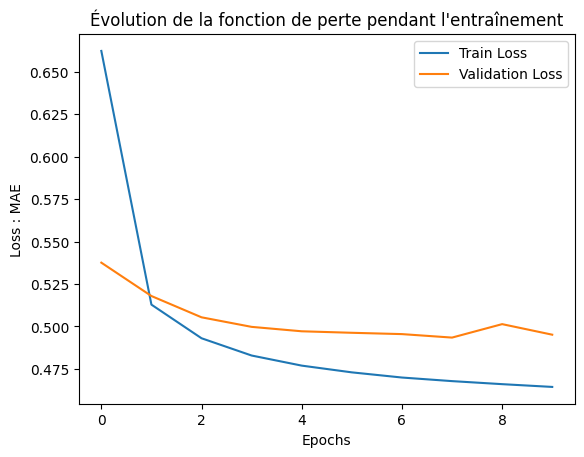

In [217]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Évolution de la fonction de perte pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Loss : MAE')
plt.legend()
plt.show()

In [194]:
import pickle
pickle.dump(history, open("history", 'wb'))

In [195]:
model.summary()

Model: "model_3"


__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 1, 10)                15000     ['input_7[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 1, 10)                15000     ['input_8[0][0]']             
                                                                                                  
 flatten_6

In [112]:

# Make predictions
predictions = model.predict([test['userId'], test['movieId']])
pd.DataFrame(predictions).describe()


5728/5728 [==============================] - 2s 260us/step


,0
count,183271.000000
mean,3.765436
std,0.539081
min,0.699845
25%,3.437812
50%,3.810703
75%,4.139025
max,5.479317


### Machine Learning avec la bibliothèque SURPRISE

In [35]:
import numpy as np 
import pandas as pd 
from surprise import Dataset 
from surprise import Reader
from surprise.model_selection import train_test_split 
from surprise.model_selection import cross_validate 
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor 
from surprise import BaselineOnly 
from surprise import KNNBasic
from surprise import KNNWithMeans 
from surprise import KNNWithZScore 
from surprise import KNNBaseline
from surprise import SVD 
from surprise import SVDpp 
from surprise import NMF
import time

In [36]:
#column_names = ['user_id', 'item_id', 'rating', 'timestamp']
#df = pd.read_csv('u.data', sep='\t', names=column_names)

#movie_titles = pd.read_csv("Movie_Id_Titles")

#df = pd.merge(df,movie_titles,on='item_id')

n_users = ratings_reduced.userId.nunique()
n_movies = ratings_reduced.movieId.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_movies))

#df = df.rename(columns={'user_id' : 'userId', 'item_id' : 'movieId'})


# Call Reader and set Rating Scale from 0.5 to 5
reader = Reader(rating_scale= (0.5, 5))
# Parse data and select only necessary files
data = Dataset.load_from_df(ratings_reduced[['userId', 'movieId','rating']], reader)

trainset, testset = train_test_split(data, test_size=.2)


Num. of Users: 1500
Num of Movies: 1500


In [38]:
# Enregistrez le temps de début
temps_debut = time.time()

# Run svd algroichm
model_SVD = SVD()
# This follows the typical sklearn train and test model building
model_SVD.fit(trainset)
#joblib.dump(model_SVD, "SVD")
predictions = model_SVD.test(testset)
# compute erros accuracy.rmse(predictions)


# Enregistrez le temps de fin
temps_fin = time.time()
duree = temps_fin- temps_debut

liste_SVD = [float(accuracy.rmse(predictions)), float(accuracy.mse(predictions)), float(accuracy.mae(predictions)), float(accuracy.fcp(predictions)), duree]

RMSE: 0.7015
MSE: 0.4921
MAE:  0.5282
FCP:  0.7052


In [39]:
temps_debut = time.time()
# Run svd algroichm
model_NP = NormalPredictor()
# This follows the typical sklearn train and test model building
model_NP.fit(trainset)
predictions = model_NP.test(testset)
lNP = []
# compute erros accuracy.rmse(predictions)

# Enregistrez le temps de fin
temps_fin = time.time()
duree = temps_fin- temps_debut

liste_NormalPredictor = [float(accuracy.rmse(predictions)), float(accuracy.mse(predictions)), float(accuracy.mae(predictions)), float(accuracy.fcp(predictions)), duree]

RMSE: 1.2016
MSE: 1.4439
MAE:  0.9520
FCP:  0.4956


In [40]:
temps_debut = time.time()
# Run svd algroichm
model_BO = BaselineOnly()
# This follows the typical sklearn train and test model building
model_BO.fit(trainset)


predictions = model_BO.test(testset)
# compute erros accuracy.rmse(predictions)


# Enregistrez le temps de fin
temps_fin = time.time()
duree = temps_fin- temps_debut

liste_BaselineOnly = [float(accuracy.rmse(predictions)), float(accuracy.mse(predictions)), float(accuracy.mae(predictions)), float(accuracy.fcp(predictions)), duree]

Estimating biases using als...
RMSE: 0.7589
MSE: 0.5759
MAE:  0.5745
FCP:  0.6403


In [41]:
temps_debut = time.time()
# Run svd algroichm
model_KNNB = KNNBasic()
# This follows the typical sklearn train and test model building
model_KNNB.fit(trainset)

predictions= model_KNNB.test(testset)

# compute erros accuracy.rmse(predictions)


# Enregistrez le temps de fin
temps_fin = time.time()
duree= temps_fin- temps_debut

liste_KNNBasic = [float(accuracy.rmse(predictions)), float(accuracy.mse(predictions)), float(accuracy.mae(predictions)), float(accuracy.fcp(predictions)), duree]


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7567
MSE: 0.5726
MAE:  0.5663
FCP:  0.6685


In [42]:
temps_debut = time.time()
# Run svd algroichm
model_KNNWM = KNNWithMeans()
# This follows the typical sklearn train and test model building
model_KNNWM.fit(trainset)

predictions = model_KNNWM.test(testset)

# compute erros accuracy.rmse(predictions)




# Enregistrez le temps de fin
temps_fin = time.time()
duree = temps_fin- temps_debut

liste_KNNWithMeans = [float(accuracy.rmse(predictions)), float(accuracy.mse(predictions)), float(accuracy.mae(predictions)), float(accuracy.fcp(predictions)), duree]

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7389
MSE: 0.5460
MAE:  0.5584
FCP:  0.6677


In [43]:
temps_debut = time.time()
# Run svd algroichm
model_KNNWZ = KNNWithZScore()
# This follows the typical sklearn train and test model building
model_KNNWZ.fit(trainset)

predictions = model_KNNWZ.test(testset)

# compute erros accuracy.rmse(predictions)

temps_fin = time.time()
duree = temps_fin- temps_debut

liste_KNNWithZScore = [float(accuracy.rmse(predictions)), float(accuracy.mse(predictions)), float(accuracy.mae(predictions)), float(accuracy.fcp(predictions)), duree]

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7408
MSE: 0.5488
MAE:  0.5573
FCP:  0.6652


In [44]:
temps_debut = time.time()
# Run svd algroichm
model_KNNBl = KNNBaseline()
# This follows the typical sklearn train and test model building
model_KNNBl.fit(trainset)


predictions = model_KNNBl.test(testset)

# compute erros accuracy.rmse(predictions)

# Enregistrez le temps de fin
temps_fin = time.time()
duree = temps_fin- temps_debut

liste_KNNBaseline = [float(accuracy.rmse(predictions)), float(accuracy.mse(predictions)), float(accuracy.mae(predictions)), float(accuracy.fcp(predictions)), duree]

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7382
MSE: 0.5450
MAE:  0.5576
FCP:  0.6674


In [45]:
temps_debut = time.time()
model_SVDpp = SVDpp()
model_SVDpp.fit(trainset)

predictions = model_SVDpp.test(testset)

# compute erros accuracy.rmse(predictions)

# Enregistrez le temps de fin
temps_fin = time.time()
duree = temps_fin- temps_debut

liste_SVDpp = [float(accuracy.rmse(predictions)), float(accuracy.mse(predictions)), float(accuracy.mae(predictions)), float(accuracy.fcp(predictions)), duree]

RMSE: 0.7008
MSE: 0.4911
MAE:  0.5283
FCP:  0.7059


In [186]:
data_model = pd.DataFrame(columns = ['NormalPredictor', 'BaselineOnly', 'KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'KNNBaseline', 'SVD', 'SVDpp'])
#data_model.index = ['SVD', 'NP', 'BO', 'KNNB', 'KNNWM', 'KNNBl', 'SVDpp']

In [187]:
data_model.NormalPredictor = liste_NormalPredictor
data_model.BaselineOnly = liste_BaselineOnly
data_model.KNNBasic = liste_KNNBasic
data_model.KNNWithMeans = liste_KNNWithMeans
data_model.KNNWithZScore = liste_KNNWithZScore
data_model.KNNBaseline = liste_KNNBaseline
data_model.SVD = liste_SVD
data_model.SVDpp = liste_SVDpp


In [188]:

noms_index = ['RMSE', 'MSE', 'MAE', 'FCP', 'Run_time (s)']

# Remplacer l'index par les noms
data_model = data_model.set_index(pd.Index(noms_index))

In [191]:
data_model.to_csv('data_model.csv', index = False)

Text(0.5, 1.0, "MSE en fonction de l'algorithme")

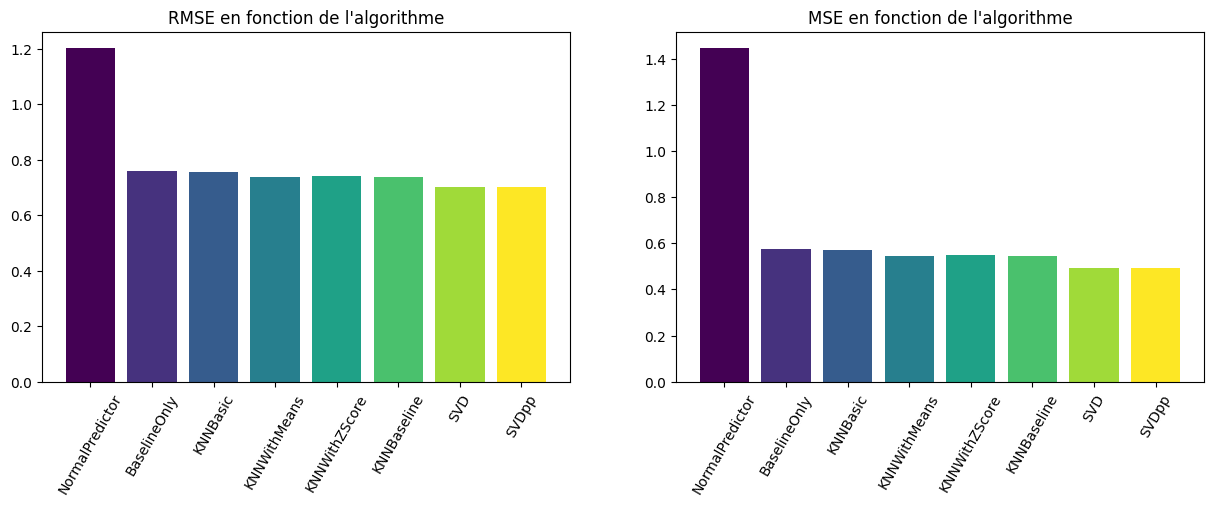

In [190]:
fig = plt.figure(figsize= (15,10))

plt.subplot(221)
plt.bar(data_model.columns, data_model.iloc[0,:], color = colors)
plt.xticks(rotation = 60)
plt.title("RMSE en fonction de l'algorithme")
plt.subplot(222)
plt.bar(data_model.columns, data_model.iloc[1,:], color = colors)
plt.xticks(rotation = 60)
plt.title("MSE en fonction de l'algorithme")

Text(0.5, 1.0, "FCP en fonction de l'algorithme")

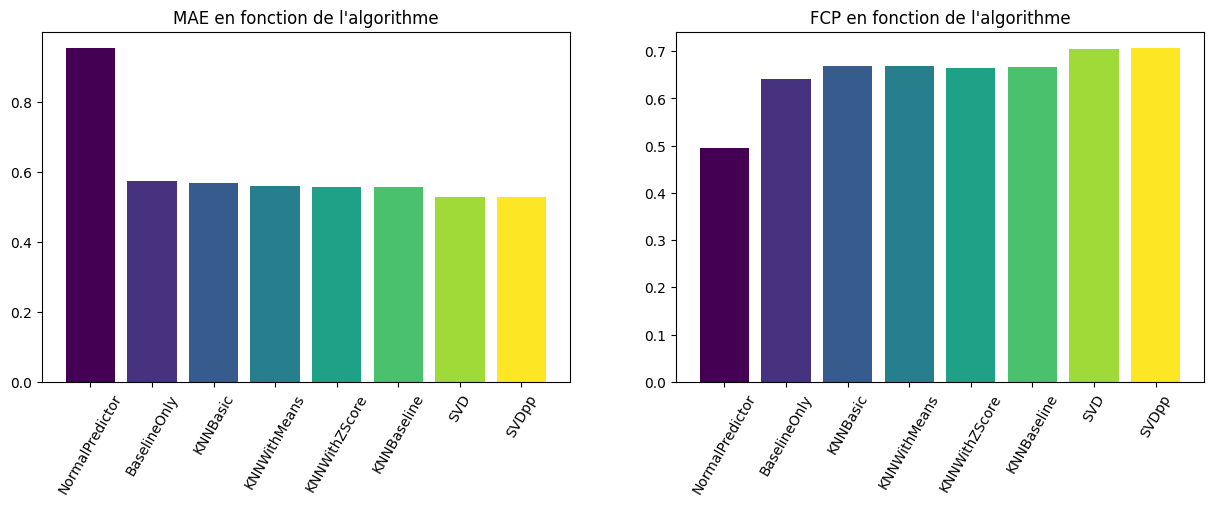

In [107]:
fig = plt.figure(figsize= (15,10))

plt.subplot(221)
plt.bar(data_model.columns, data_model.iloc[2,:], color = colors)
plt.xticks(rotation = 60)
plt.title("MAE en fonction de l'algorithme")
plt.subplot(222)
plt.bar(data_model.columns, data_model.iloc[3,:], color = colors)
plt.xticks(rotation = 60)
plt.title("FCP en fonction de l'algorithme")


Text(0.5, 1.0, 'Répartition du genre des passagers')

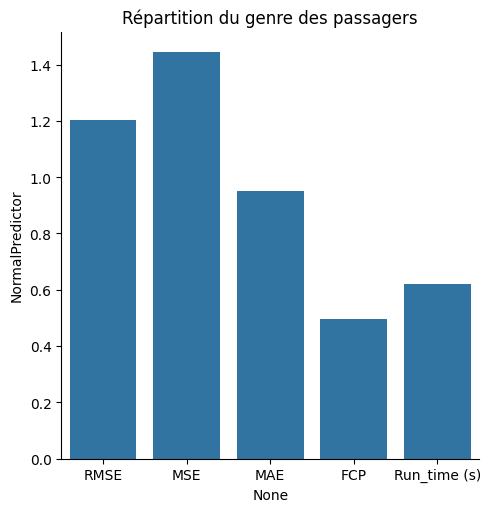

In [185]:
sns.catplot(x = data_model.columns, y = data_model.iloc[0,:], kind = 'bar')
plt.title("Répartition du genre des passagers")

Text(0.5, 1.0, "Run_time en fonction de l'algorithme")

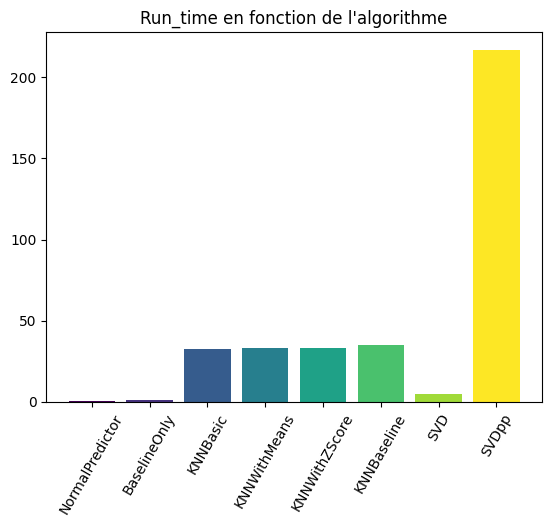

In [100]:
colors = plt.cm.viridis(np.linspace(0, 1, data_model.columns.shape[0]))
plt.bar(data_model.columns, data_model.iloc[4,:], color = colors)
plt.xticks(rotation = 60)
plt.title("Run_time en fonction de l'algorithme")


In [ ]:
data_model.to_csv('data_model.csv', index = True)

In [110]:

# Recherche des meilleurs hyperparamètres
param_grid = {
    'n_factors': [10, 100, 500],
    'n_epochs': [5, 20, 50], 
    'lr_all': [0.001, 0.005, 0.02],
    'reg_all': [0.005, 0.02, 0.1]}

gs_model = GridSearchCV(
    algo_class = SVD,
    param_grid = param_grid,
    n_jobs = -1,
    joblib_verbose = 5)

gs_model.fit(data)

# Entrainement du modèle avec les paramètres qui minimisent la RMSE
best_SVD = gs_model.best_estimator['rmse']
best_SVD.fit(trainset)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 13.2min finished


In [111]:
predictions_best = best_SVD.test(testset)

accuracy.rmse(predictions_best)
accuracy.mse(predictions_best)
accuracy.mae(predictions_best)
accuracy.fcp(predictions_best)

RMSE: 0.7008
MSE: 0.4911
MAE:  0.5279
FCP:  0.7055


0.7054728724849082

In [125]:
print(gs_model.best_score['rmse'])
print(gs_model.best_score['mae'])

# On ne trouve pas mieux qu'avec le SVD par défaut.

0.69922740859962
0.5267006659394949


In [127]:
# Define user id and movie id in the string format as required by the package and the data
uid = str (603)
iid = str(1387)
# Get predictions
pred = gs_model.predict(uid, iid, r_ui=4, verbose = True)


TypeError: BaseSearchCV.predict() got an unexpected keyword argument 'r_ui'